In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math
import pywt
import re

In [2]:
#  Parameters of the paper:

K = 2
# lambda_k = 1/k
# tau_k = sigma*lambda_k/4
N1 = 10
N2 = 32

## Block Matching

### Extracting patches

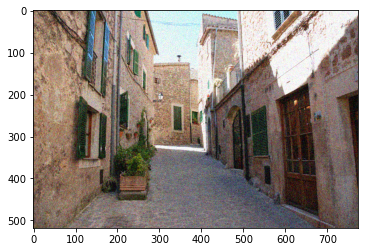

In [174]:
img = plt.imread('FFDNET IPOL/noisy.png')
plt.imshow(img)
plt.show()

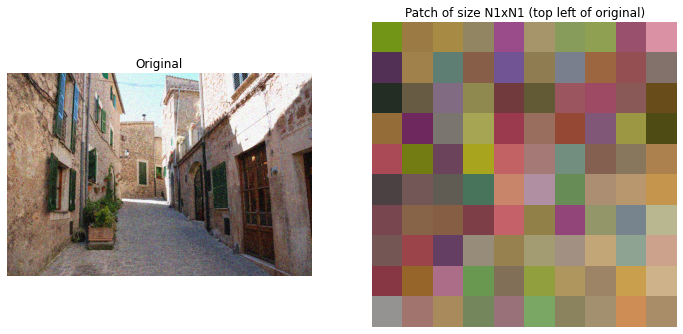

In [175]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(img[:10,:10,:])
plt.axis('off')
plt.title('Patch of size N1xN1 (top left of original)')

plt.show()

In [176]:
# Choix des patchs: pas de overlapp sauf dans les coins (ceci pour éviter une quantité trop grandes de patchs pour la matrice de similarité)

def dividing_into_patches(img):
    """Divides an input image into patches of size N1xN1"""
    n, p = img.shape[0], img.shape[1]
    patches = []
    n_10, p_10 = n//10, p//10
    for i in range(n_10+1):
        for j in range(p_10+1):
            if i < n_10 and j < p_10:
                patches.append(img[i*N1:i*N1+10, j*N1:j*N1+10, :])
            elif i == n_10 and j < p_10:
                patches.append(img[n-10:n, j*N1:j*N1+10, :])
            elif i < n_10 and j == p_10:
                patches.append(img[i*N1:i*N1+10, p-10:p, :])
            elif i == n_10 and j == p_10:
                patches.append(img[n-10:n, p-10:p, :])
    return np.array(patches)       

In [177]:
patches = dividing_into_patches(img)
print('There are: ' + str(patches.shape[0]) + ' patches in this image (N = (n//10+1)*(p//10+1))')

There are: 4056 patches in this image (N = (n//10+1)*(p//10+1))


### Similarity Matrix

In [178]:
def similarity_matrix(patches):
    """Computes the similarity matrix between the patches
    Returns a matrix of size N1xN1"""
    size = patches.shape[0]
    similarity = np.zeros((size,size))
    sim = 0

    # similarity computed with the Frobenius norm
    # leave the 0 similarity with itself to make sure every patch will be in S
    for i in range(size):
        for j in range(size):
            sim = np.linalg.norm(patches[i] - patches[j])
            similarity[i][j] = sim
    return similarity      

In [179]:
similarity = similarity_matrix(patches)
print(similarity)

[[0.         3.3834846  3.36762977 ... 3.98874831 4.00399494 3.84481978]
 [3.3834846  0.         3.3212564  ... 4.26994038 4.18441296 4.09139919]
 [3.36762977 3.3212564  0.         ... 3.64392662 3.70970678 3.59715605]
 ...
 [3.98874831 4.26994038 3.64392662 ... 0.         2.3412652  2.55529857]
 [4.00399494 4.18441296 3.70970678 ... 2.3412652  0.         2.37265611]
 [3.84481978 4.09139919 3.59715605 ... 2.55529857 2.37265611 0.        ]]


In [181]:
def building_the_look_up_table(similarity):
    """Builds a dictionnary by taking for each patch, the
    N2 most similar patches (including itself to make sure
    that all patches are in S"""
    S = {}
    n = similarity.shape[0]
    for i in range(n):
        idx = np.argpartition(similarity[i], N2)
        S['patch ' + str(i)] = idx[:N2]
    return S

In [182]:
look_up_table = building_the_look_up_table(similarity)
print(look_up_table['patch 0'])

[3440 3050 3127    0 3748 2974 2896 1783  392 2645 3591 2361 3123 2106
 3288 3515 1315 3434 3043 1694 1395 3826 3207 3206 3516 2490 3909 3129
 3517 1784 1850 2901]


## Separating RBG

In [51]:
red_noise = patches[:,:,:,0]
green_noise = patches[:,:,:,1]
blue_noise = patches[:,:,:,2]

In [52]:
print(red_noise.shape)

(4056, 10, 10)


## NLF Filter

In [53]:
def building_gkj_array(patch_ind, look_up_table, patches):
    gkj = np.zeros((N1,N1,N2))
    idx = look_up_table['patch ' + str(patch_ind)]
    for i in range(len(idx)):
        gkj[:,:,i] = patches[idx[i]]
    return gkj

In [54]:
gkj_tilde = building_gkj_array(1, look_up_table, red_noise)
print(gkj_tilde[0][0])

[0.45882353 0.52941179 0.47450981 0.64313728 0.59215689 0.65490198
 0.55686277 0.49803922 0.36862746 0.72156864 0.49019608 0.70980394
 0.61176473 0.47058824 0.72549021 0.58431375 0.58431375 0.66666669
 0.5529412  0.40392157 0.51764709 0.49411765 0.627451   0.51372552
 0.47450981 0.58431375 0.53333336 0.66274512 0.7019608  0.64313728
 0.65098041 0.42352942]


### Wavelet Function Python

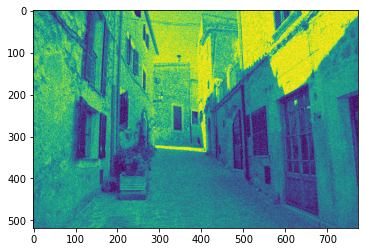

In [183]:
noisy_img = plt.imread('FFDNET IPOL/noisy.png')
red_noise_img = noisy_img[:,:,0]
green_noise_img = noisy_img[:,:,1]
blue_noise_img = noisy_img[:,:,2]
plt.imshow(red_noise_img)

In [152]:
pywt.families()  # use Haar wavelet

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

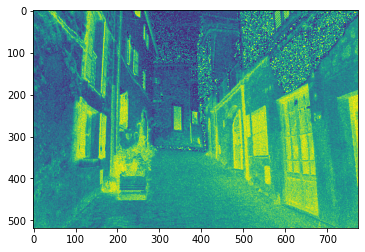

In [185]:
wavelet = pywt.Wavelet('haar')
coeffs = pywt.wavedec(red_noise_img, 'haar', level = 0)
y = np.clip(pywt.waverec(coeffs, 'haar'),0,255).astype(np.uint8)
plt.imshow(y-red_noise_img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


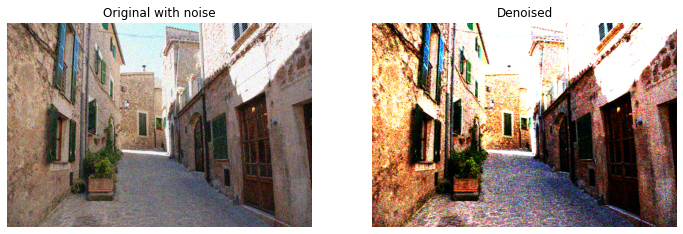

In [188]:
# Using  function dwt
tau = 10

a_red, b_red = pywt.dwt(red_noise_img, 'haar')
a_thres_red, b_thres_red = Gamma(a_red,tau), Gamma(b_red,tau)
red_no_noise = pywt.idwt(a_thres_red, b_thres_red, 'haar')

a_green, b_green = pywt.dwt(green_noise_img, 'haar')
a_thres_green, b_thres_green = Gamma(a_green,tau), Gamma(b_green,tau)
green_no_noise = pywt.idwt(a_thres_green, b_thres_green, 'haar')

a_blue, b_blue = pywt.dwt(blue_noise_img, 'haar')
a_thres_blue, b_thres_blue = Gamma(a_blue,tau), Gamma(b_blue,tau)
blue_no_noise = pywt.idwt(a_thres_blue, b_thres_blue, 'haar')

reconstruction = np.zeros((red_no_noise.shape[0], red_no_noise.shape[1], 3))
reconstruction[:,:,0] = red_no_noise
reconstruction[:,:,1] = green_no_noise
reconstruction[:,:,2] = blue_no_noise

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original with noise')

plt.subplot(1, 2, 2)
plt.imshow(reconstruction*255) #Ajout de ce coeff multiplicatif sinon les coeffs sont trop petits
plt.axis('off')
plt.title('Denoised')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


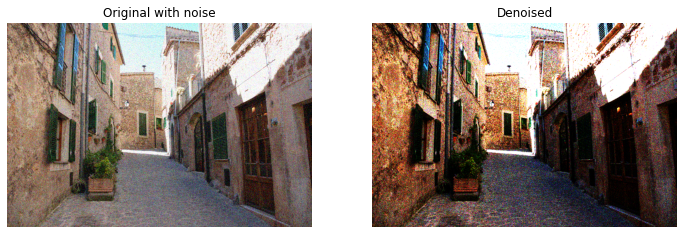

In [190]:
# Using function waverec
tau = 10

a_red = pywt.wavedec(red_noise_img, 'haar', level = 0)
a_thres_red = Gamma(np.array(a_red),tau)
red_no_noise = np.clip(pywt.waverec(list(a_thres_red), 'haar'),0,255)

a_green = pywt.wavedec(green_noise_img, 'haar', level = 0)
a_thres_green = Gamma(np.array(a_green),tau)
green_no_noise = np.clip(pywt.waverec(list(a_thres_green), 'haar'),0,255)

a_blue = pywt.wavedec(blue_noise_img, 'haar', level = 0)
a_thres_blue = Gamma(np.array(a_blue),tau)
blue_no_noise = np.clip(pywt.waverec(list(a_thres_blue), 'haar'),0,255)

reconstruction = np.zeros((red_no_noise.shape[0], red_no_noise.shape[1], 3))
reconstruction[:,:,0] = red_no_noise
reconstruction[:,:,1] = green_no_noise
reconstruction[:,:,2] = blue_no_noise

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original with noise')

plt.subplot(1, 2, 2)
plt.imshow(reconstruction*255)
plt.axis('off')
plt.title('Denoised')

plt.show()

### Article's Transform

In [17]:
def Gamma(q, tau):
    return q**3/(q**2+tau**2)

In [104]:
#sigma = 30, 50, 75

def transform_haar_wavelet(patch_ind,patches,k,sigma):
    tau_k = (1/4)*sigma/k
    gkj_tilde = building_gkj_array(patch_ind, look_up_table, patches)
    a_k, b_k = pywt.dwt(gkj_tilde, 'haar')
    gam_a_k = Gamma(a_k, tau_k)
    gam_b_k = Gamma(b_k, tau_k)
    gkj_hat = pywt.idwt(gam_a_k,gam_b_k, 'haar')
    return gkj_hat

In [55]:
sigma = 30
print(transform_haar_wavelet(1,red_noise,1,sigma).shape)

(10, 10, 32)


In [41]:
def transform_over_all_img(look_up_table,patches,k,sigma):
    n = patches.shape[0]
    transform = []
    for i in range(n):
        gkj_tilde = building_gkj_array(i, look_up_table, patches)
        gkj_hat = transform_haar_wavelet(i,patches,k,sigma)
        transform.append(gkj_hat)
    return np.array(transform)

In [56]:
k = 1
sigma = 30
transform_red = transform_over_all_img(look_up_table,red_noise,k,sigma)
print(transform_red.shape)

(4056, 10, 10, 32)


### Image Estimate

In [125]:
def weight_j(patch_ind, look_up_table, patches, tau):
    gkj_tilde = building_gkj_array(patch_ind, look_up_table, patches)
    a_k, b_k = pywt.dwt(gkj_tilde, 'haar')
    wkj = (np.linalg.norm(a_k**2/(a_k**2+tau**2)) + np.linalg.norm(b_k**2/(b_k**2+tau**2)))**(-2)
    return wkj

In [126]:
print(weight_j(6, look_up_table, red_noise, 7.5))

3.7438855802261424


In [74]:
def all_weights(look_up_table, patches, tau):
    n = patches.shape[0]
    w = []
    for i in range(n):
        w.append(weight_j(i, look_up_table, patches, tau))
    return w

In [75]:
print(len(all_weights(look_up_table, red_noise, 7.5)))

4056


In [76]:
def inverse_look_up_table(patches, look_up_table):
    inv = {}
    n = patches.shape[0]
    for i in range(n):
        for patch in look_up_table:
            if i in look_up_table[patch]:
                if ('patch '+str(i)) in inv.keys():
                    inv['patch '+str(i)] += [int(re.findall(r'\d+', patch)[0])]
                else: 
                    inv['patch '+str(i)] = [int(re.findall(r'\d+', patch)[0])]
    return inv

In [77]:
inv = inverse_look_up_table(patches, look_up_table)
print(len(inv))

4056


In [78]:
def new_patches(look_up_table, inv, patches, tau, img):
    weights = all_weights(look_up_table, patches, tau)
    n, p = img.shape[0], img.shape[1]
    new_patches = []
    n_cpt, p_cpt = 0, 0
    for patch in inv:
        summing = np.zeros((N1,N1))
        for pat in inv[patch]:
            summing += weights[pat]*patches[pat]
        new_patches.append(summing)
    return np.array(new_patches)

In [167]:
new_patch = new_patches(look_up_table, inv, red_noise, 7.5, img)

In [168]:
def image_estimate(new_patches, img):
    n, p = img.shape[0], img.shape[1]
    new_image = np.zeros((n, p))
    n_10, p_10 = n//10, p//10
    cpt = 0
    for i in range(n_10+1):
        for j in range(p_10+1):
            if i < n_10 and j < p_10:
                new_image[i*N1:i*N1+N1, j*N1:j*N1+N1] = new_patches[cpt]
            elif i == n_10 and j < p_10:
                new_image[i*N1:n, j*N1:j*N1+N1] = new_patches[cpt][N1-(n-i*N1):,:]
            elif i < n_10 and j == p_10:
                new_image[i*N1:i*N1+N1, j*N1:p] = new_patches[cpt][:,N1-(p-j*N1):]
            elif i == n_10 and j == p_10:
                new_image[i*N1:n, j*N1:p] = new_patches[cpt][N1-(n-i*N1):,N1-(p-j*N1):]
        cpt += 1
    return new_image

In [169]:
img_est = image_estimate(new_patch, img)

In [170]:
print(img_est)

[[13.13760424 15.56842941 18.5505724  ... 18.95358968 18.54637516
  17.45067602]
 [11.96027327 13.88823295 12.31485343 ... 18.27030301 17.88100225
  14.77757967]
 [10.53295293 10.67207766 14.58860433 ... 18.52590787 17.01059711
  14.16232806]
 ...
 [13.84718543 15.10047176 14.87153497 ... 15.49044314 15.3704052
  15.77164996]
 [14.98643035 15.31574249 14.81504774 ... 15.32926086 16.00458008
  16.06588224]
 [15.22830462 14.98085821 15.31381911 ... 15.36746812 15.97273058
  15.69336331]]


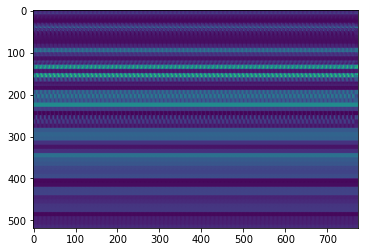

In [171]:
plt.imshow(img_est)
plt.show()